This is my first attempt to solve the Spaceship Titanic Data science competition on the data science platform Kaggle.

# Preliminary: imports and load the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import os

In [2]:
# variable to determine whether the notebook is running on Collab or not
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

Please make sure to download the data and have it in the same directory as this notebook when running it.

In [3]:
import os
from zipfile import ZipFile

DOWNLOAD_DIR = "sample_data" if IN_COLAB else os.getcwd() 
file_name = "spaceship-titanic.zip"
file_name_no_zip = "spaceship-titanic"
loc = os.path.join(DOWNLOAD_DIR, file_name)
# opening the zip file in READ mode

if not os.path.isdir(os.path.join(DOWNLOAD_DIR, file_name_no_zip)):
    with ZipFile(loc, 'r') as zip_ref:
        zip_ref.extractall()
        print('Done!')

Done!


In [4]:
train_loc = os.path.join(os.getcwd(), "train.csv")
test_loc = os.path.join(os.getcwd(), "test.csv")

df = pd.read_csv(train_loc)
df_test = pd.read_csv(test_loc)

# Helper functions
in this subsection I write a number of functions to frequently use later.

In [5]:
# a function to delete columnsfrom both the train and test datasets
def drop_cols(cols, df_train: pd.DataFrame, df_test: pd.DataFrame):
    if isinstance(cols, str):
        df1 = df_train.drop(cols, axis=1)
        df2 = df_test.drop(cols, axis=1)
    else:
        df1 = df_train.drop(columns=cols)
        df2 = df_test.drop(columns=cols)
    return df1, df2

In [6]:
def new_col_names(old_new_names, df_train ,df_test):
    try:    
        df = df_train.rename(columns=old_new_names)
        df_test = df_test.rename(columns=old_new_names)
        return df, df_test
    except:
        df_no_col = [col for col in old_new_names.keys if col not in df.columns]
        df_test_no_col = [col for col in old_new_names.keys if col not in df_test.columns]
        print("{cols} are not in the {dataf}".format(df_no_col, "training dataset"))
        print("{cols} are not in the {dataf}".format(df_test_no_col, "test dataset"))


In [7]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_encoder(df: pd.DataFrame, features_names: list=None):
    # select all categorical features if none of them were specified
    if features_names is None:
        features_names = df.select_dtypes(include=['object']).columns.tolist()
    # define the encoder
    
    ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False, dtype=np.int64)
    for f in features_names:        
        try:
            unique_values = np.unique(df[f])
        except:
            unique_values = list(df[f].value_counts().index)
        
        # if there is only one unique value in the column, then this column is to be dropped
        if len(unique_values) <= 1 :
            break
        # the names for the  newly-created features
        new_names = [f'{f}_{u}' for u in unique_values[1:]]
        new_values = ohe.fit_transform(df[[f]])
        print(ohe.categories_)
        df[new_names] = new_values
    
    return df


In [8]:
! pip install empiricaldist

In [ ]:
from empiricaldist import Cdf

def display_cdfs(data:pd.DataFrame, y:str, feat:list, feat_values:list=None):
    if feat_values is None:
        feat_values = np.unique(data[feat])
    
    for v in feat_values:
        d = data[data[feat] == v][y]
        data_cdf = Cdf.from_seq(d)
        data_cdf.plot(label=v)

    plt.legend()
    plt.xlabel(f'{y}')
    plt.ylabel(f'cdf of {feat}')
    plt.show()   

def compare_cdfs(data:pd.DataFrame, ys:list, features:list, feat_values:dict=None):
    if feat_values is None:
        feat_values = {}
    
    for y in ys:
        for f in features:
            if f in feat_values:
                display_cdfs(data, y, f, feat_values[f])
            else:
                display_cdfs(data, y, f)
                


In [ ]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    # find the number of nans in each column
    total = df.isnull().sum().sort_values(ascending=False)
    # calculate the percentage of missing values in each column
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    # convert the results into a dataframe
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [ ]:
# let' define a function that applies a function to either 
# the whole dataframe or certain columns on the dataframe

def apply_functions(df_train, df_val, funcs, col_names=None):
    # either have one function passed that should be applied to the whole dataframe
    # or have an equal number of columns and functions where each funtion will be applied to the corresponding column
    all_data = callable(funcs) and col_names is None
    col_funcs = True
    #  if the funcs argument is indeed a function, then the code below will raise an error 
    try:
        col_funcs = (all([callable(f) for f in funcs]) and len(funcs) == len(col_names))
    except:
        col_funcs = False
    
    assert all_data or col_funcs
        
    if col_names is None: # if the function is to be applied on the whole dataframe
        df = df_train.apply(funcs, axis=1)
        df_test = df_val.apply(funcs, axis=1)
    else:
        df = df_train.copy()
        df_test = df_val.copy()

        for col, f in zip(col_names, funcs):
            df[col] = df[col].apply(f)
            df_test[col] = df_test[col].apply(f)
            
    return df, df_test

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [ ]:
# these represent a backup of the original data for later use
train_data = pd.read_csv(train_loc)
test_data = pd.read_csv(test_loc)

In [ ]:
def create_submission(estimator, X_train, y, X_test, estimator_name):
    estimator.fit(X_train, y)
    y_pred = pd.DataFrame(data=estimator.predict(X_test), columns=['Transported'])
    y_pred['PassengerId'] = test_data['PassengerId']
    y_pred['Transported'] = y_pred['Transported'].astype(bool)
    # y_pred = y_pred.loc[:, ['PassengerId', 'Transported']]
    # set the index to the passenger's id
    y_pred.set_index("PassengerId", inplace=True)
    y_pred.to_csv(os.path.join(os.getcwd(), f"{estimator_name} submission.csv")) 
    return y_pred
    

# MvP
In this section, I will try to build a basic, minimal machine learning pipeline to estimate the baseline performance and later proceed to enrich the data.

In [ ]:
df.head()
# let's first seperate the predictors from the label
# rename the label column to 'y'
df = df.rename(columns={"Transported":"y"})
df['y'] = df['y'].astype(int)
y = df['y']

df, df_test = drop_cols("PassengerId", df, df_test)

df, df_test = new_col_names(str.lower, df, df_test)

new_names = {"foodcourt":"food", "shoppingmall": "mall", "roomservice": "room",
            "homeplanet":"home", "destination": "des", "vrdeck":"deck", "cryosleep":"sleep"}

df, df_test = new_col_names(new_names, df, df_test)

df_org = df.copy()
df_test_org = df_test.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   home    8492 non-null   object 
 1   sleep   8476 non-null   object 
 2   cabin   8494 non-null   object 
 3   des     8511 non-null   object 
 4   age     8514 non-null   float64
 5   vip     8490 non-null   object 
 6   room    8512 non-null   float64
 7   food    8510 non-null   float64
 8   mall    8485 non-null   float64
 9   spa     8510 non-null   float64
 10  deck    8505 non-null   float64
 11  name    8493 non-null   object 
 12  y       8693 non-null   int64  
dtypes: float64(6), int64(1), object(6)
memory usage: 883.0+ KB


In [ ]:
# we can see we have a couple of missing values at each column. Nevertheless with very small portions.
# It might be useful to imput them accordingly.
# let's see how many rows have at least one nan  value 
print(df.shape)
df_non_nan = df.dropna()
df_non_nan.shape
# losing more than 2000 rows is indeed not a good idea. Let's try to impute the values

(8693, 13)


(6606, 13)

In [ ]:
# consider non-numerical values
object_type = "object"
cat_type = 'category'
non_num_cols = list(df.select_dtypes([object_type, cat_type]).columns)
print(non_num_cols)
num_cols = list(df.select_dtypes(np.number).columns)
print(num_cols)

['home', 'sleep', 'cabin', 'des', 'vip', 'name']
['age', 'room', 'food', 'mall', 'spa', 'deck', 'y']


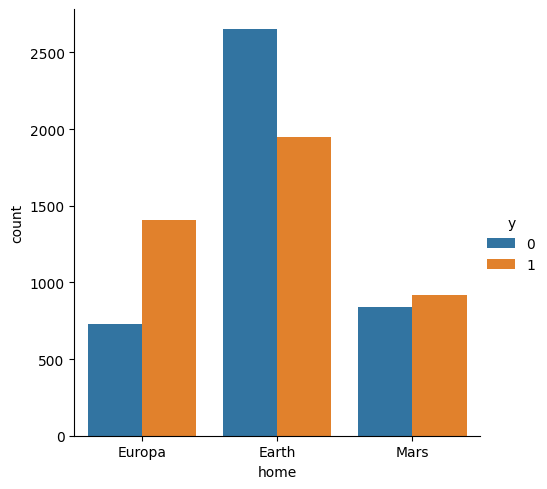

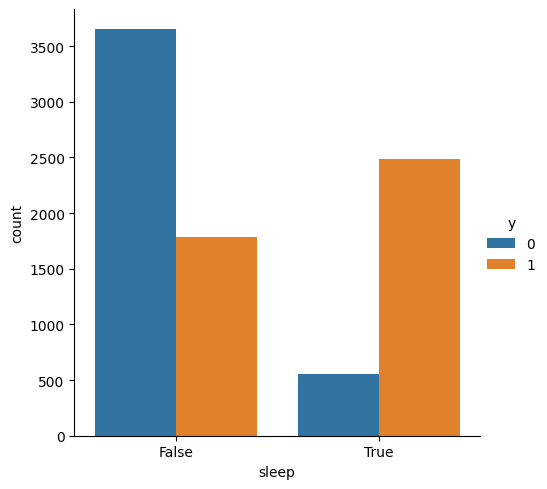

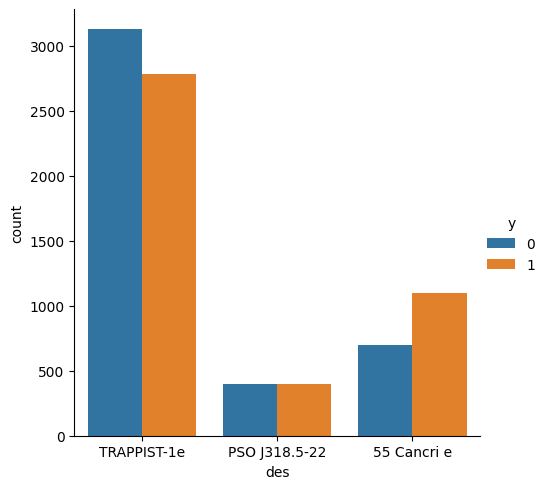

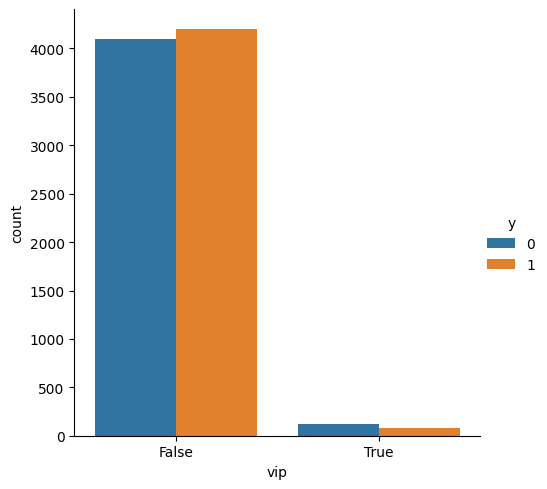

In [ ]:
# let's try to understand how the different column behaves in general
for c in non_num_cols:
    if len(df.value_counts(c)) <= 10:
        sns.catplot(kind='count', data=df, x=c, hue='y')
        plt.show()      

Remarks:
* among the categorial features, the most informative feature seems to be CyroSleep. Sleeping passengers are likely to be teleported 
* VIP is not really that informative, as for both VIP and non-VIP, the passengers are almost equally distributed 
* destination and homePlanet as they are currently might not be really informative
* maybe some insight could be extracted from cabin and name: at the moment, they will be dropped


In [ ]:
# let's drop the name and cabin features
df, df_test = drop_cols(['name', 'cabin'], df, df_test)

In [ ]:
# let's consider the distributions of numerical columns
print(df.describe()) 

               age          room          food          mall           spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

               deck            y  
count   8505.000000  8693.000000  
mean     304.854791     0.503624  
std     1145.717189     0.500016  
min        0.000000     0.000000  
25%        0.000000     0.000000  
50%        0.000000     1.000000  
75%       46.000000     1.000000  
max    24133.0000

it is easy to see that the maximum values for each of the services in the Titanic SpaceShip are extravagent to say the least.
This should be investigated further.

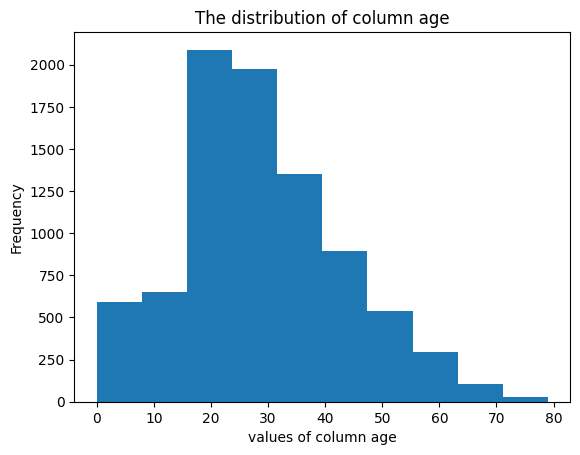

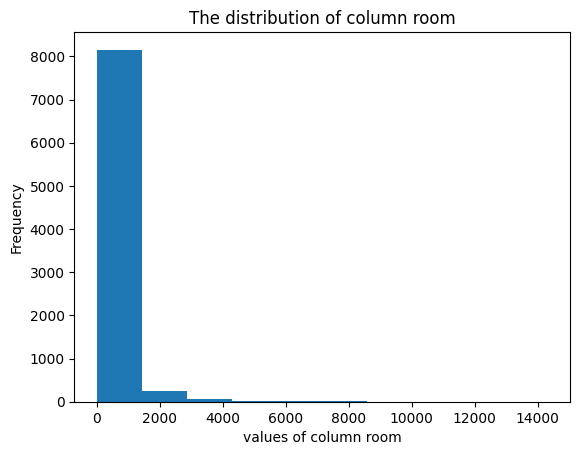

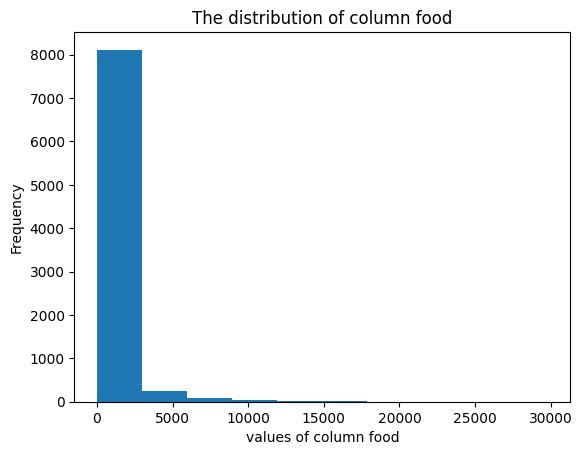

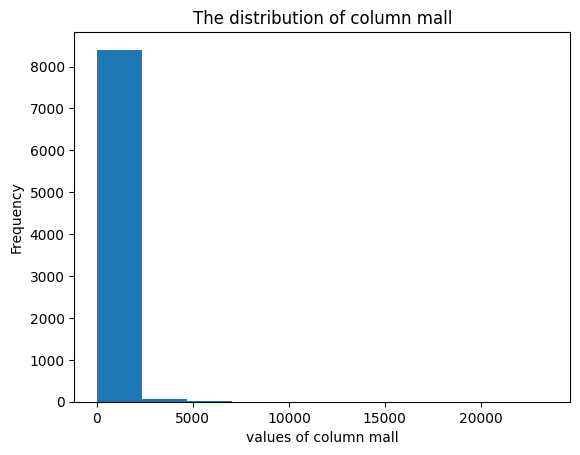

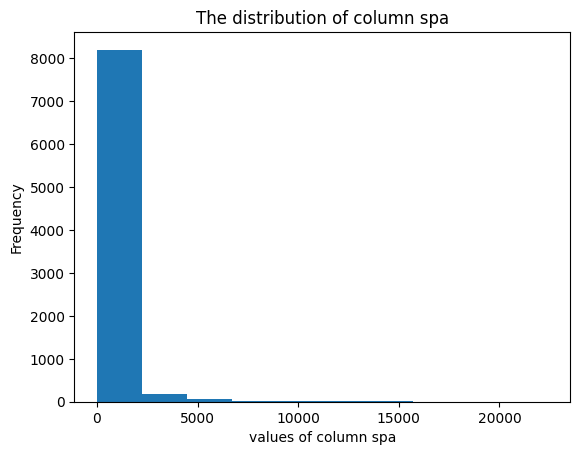

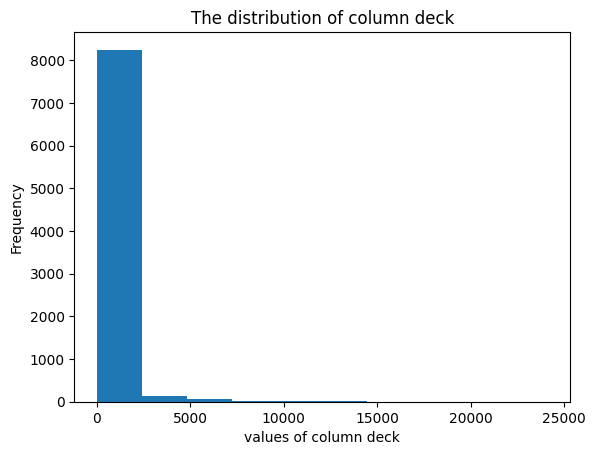

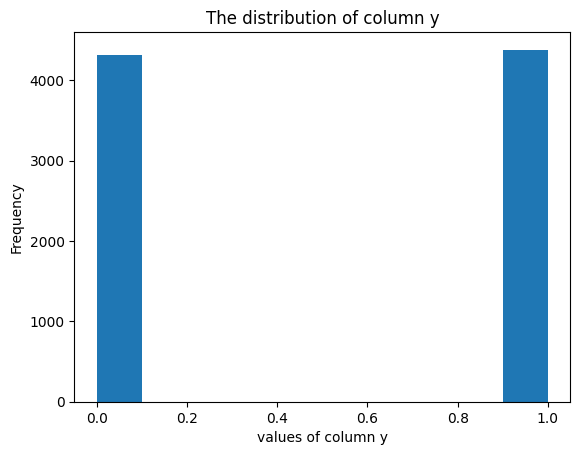

In [ ]:
for n in num_cols:
    g = df[n].plot(kind='hist')
    g.set(xlabel=f"values of column {n}", ylabel="Frequency")
    g.set_title(f'The distribution of column {n}')
    plt.show()

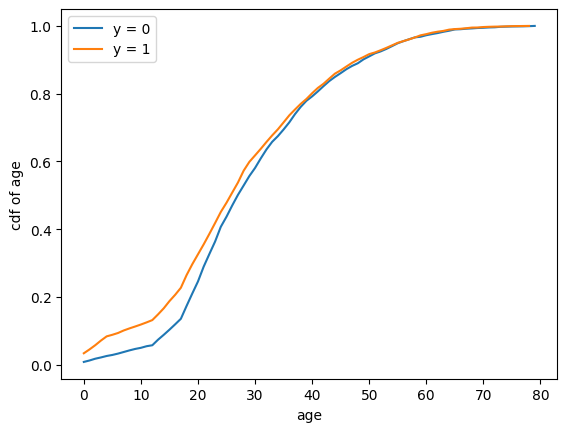

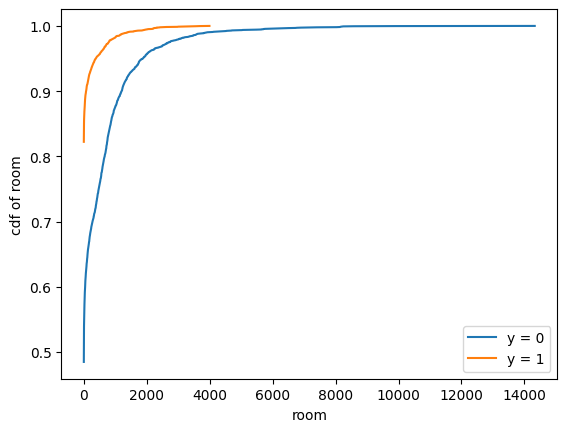

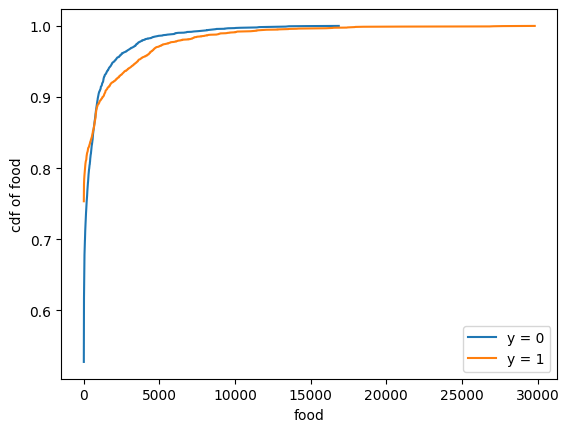

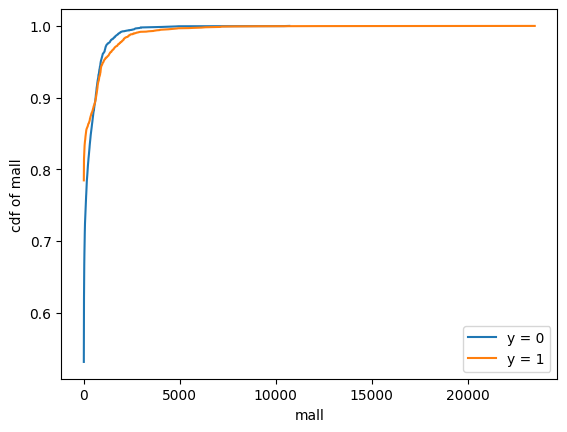

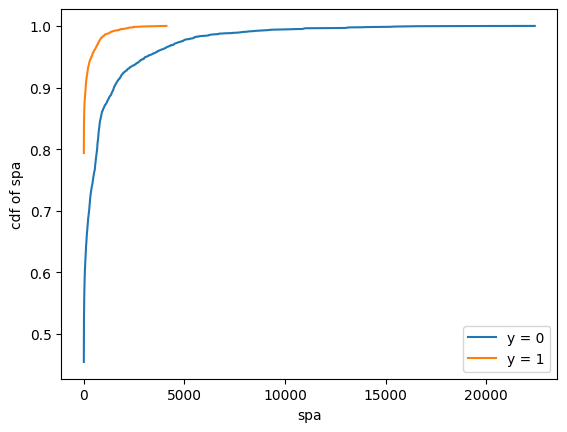

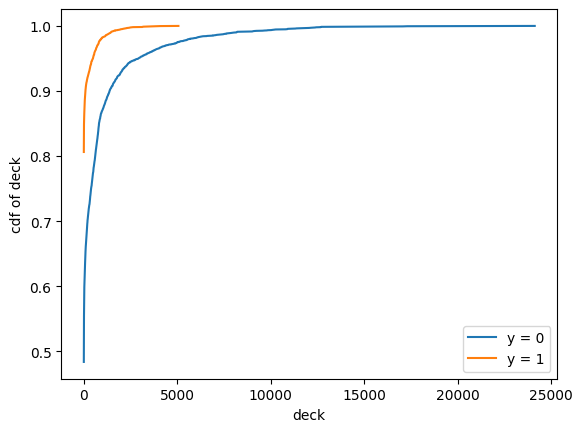

In [ ]:
# let's see how these features correlate with "y"
from empiricaldist import Cdf
for n in num_cols[:-1] :
    d1 = df[df['y'] == 0][n]
    d2 = df[df['y'] == 1][n]
    cdf1 = Cdf.from_seq(d1)
    cdf1.plot(label="y = 0")
    
    cdf2 = Cdf.from_seq(d2)
    cdf2.plot(label="y = 1")
    plt.legend()
    plt.xlabel(f'{n}')
    plt.ylabel(f'cdf of {n}')
    plt.show()   

    

* We can see that roomservice + vrdeck + spa share very similar distribution between the different classes (transported and not transported): they can be possibly be combined into a single feature
* the foodcourt and shoppingmall seem to be similar as well


In [ ]:
# let's try to understand the percentage of missing values at each column
draw_missing_data_table(df)

,Total,Percent
sleep,217,0.024963
mall,208,0.023927
vip,203,0.023352
home,201,0.023122
deck,188,0.021627
food,183,0.021051
spa,183,0.021051
des,182,0.020936
room,181,0.020821
age,179,0.020591


only few missing values at each column, using "mean" or "median" imputing does not seem like a very bad idea for numerical columns
as for cyrosleep and vip, it might be worth veryfing a certain assumption
1. people in cyrosleep do not spend money at all: 
2. vip: spend significantly more than the rest of the passengers

In [ ]:
# first let's add a total_spending column where it calculates the sum of money spent on different services

spending_cols = ['deck','room','food','spa', 'mall']
def total_spent(row):
    spending_cols = ['deck','room','food','spa', 'mall']
    row['total'] = row[spending_cols].sum()
    return row
df, df_test = apply_functions(df, df_test, total_spent)

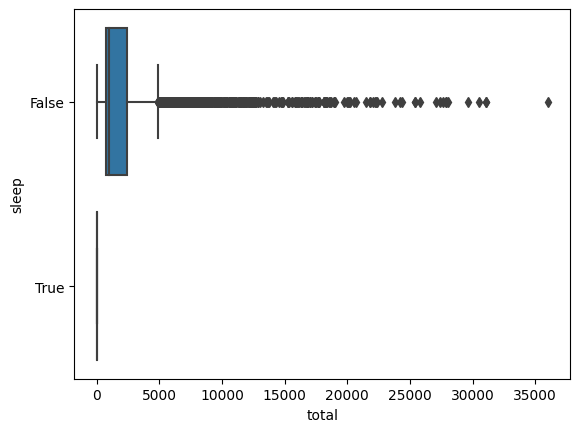

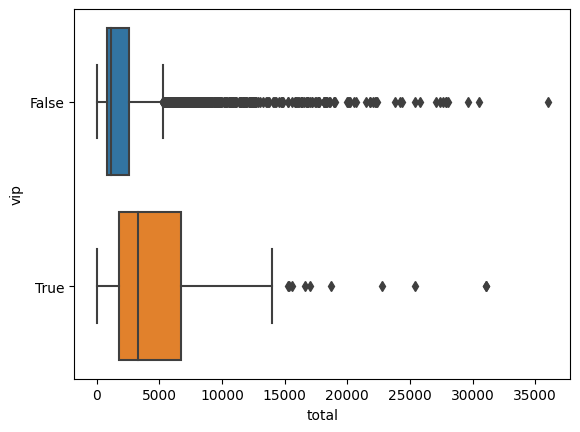

In [ ]:
# let's verify our hypothesis

sns.boxplot(data=df, x='total', y='sleep', orient='h')
plt.show()

# let's verify the vip hypothesis

data = df[(df['total'] > 0)]
sns.boxplot(data=data, x='total', y='vip', orient='h')
plt.show()

In [ ]:
# the first hypothesis is indeed verified: 
# total == 0 <=> passenger is asleep

# the second hypothesis, is relatively in the correct direction, the mean spending of a vip passenger is significantly 
# larger than the non-vip passenger. it is not possible to determine with high certainty that a high spender is a vip

def impute_total_sleep(row):
    if row['total'] == 0 or row['sleep']:
        for c in spending_cols:
            row[c] = 0
        row['sleep'] = True
        
    return row

In [ ]:
spending_cols.append('total')
df_spent = df[df['total']>0]
df_spent_vip = pd.pivot_table(data=df_spent, index=['vip'], values=spending_cols, aggfunc=['median'])
print(df_spent_vip)

      median                                 
        deck   food mall  room    spa   total
vip                                          
False   11.5   16.0  7.0  12.0   19.0  1154.0
True   132.0  488.0  1.0   7.0  133.0  3332.0


In [ ]:
import math

def impute_total_vip(row):
    if math.isnan(row['vip']):
        # set the rows with 'vip' missing values to either True or False depending on the
        # total spending 
        if row['total'] > df_spent_vip.loc[False, ('median', 'total')]:
            row['vip'] = True
        else:
            row['vip'] = False
     
    for c in spending_cols:
        if math.isnan(row[c]):
            row[c] = df_spent_vip.loc[row['vip'], ('median', c)]
    return row

df, df_test = apply_functions(df, df_test, impute_total_sleep)
df, df_test = apply_functions(df, df_test, impute_total_vip)

In [ ]:
# let's use the median for the moment to impute age
# and the mode for des and home features
from sklearn.impute import SimpleImputer

mode_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

# impute des and home features

planets=['home', 'des']

df [planets] = pd.DataFrame(data=mode_imputer.fit_transform(df[planets]), columns=planets)
df [['age']] = pd.DataFrame(data=median_imputer.fit_transform(df[['age']]), columns=['age'])

df_test[planets] = pd.DataFrame(data=mode_imputer.transform(df_test[planets]), columns=planets)
df_test[['age']] = pd.DataFrame(data=median_imputer.transform(df_test[['age']]), columns=['age'])


In [ ]:
# as expected we have no missing values anymore
draw_missing_data_table(df)

,Total,Percent
home,0,0.0
sleep,0,0.0
des,0,0.0
age,0,0.0
vip,0,0.0
room,0,0.0
food,0,0.0
mall,0,0.0
spa,0,0.0
deck,0,0.0


In [ ]:
# final step in the baseline pipeline is to encode the categorial features 
# and convert the boolean ones numerical

df = one_hot_encoder(df, planets)
df_test = one_hot_encoder(df_test, planets)

# remove the original columns
df, df_test = drop_cols(planets, df, df_test)

def set_bool_int(row):
    row['sleep'] = int(row['sleep'])
    row['vip'] = int(row['vip'])
    return row

df, df_test = apply_functions(df, df_test, set_bool_int)


[array(['Earth', 'Europa', 'Mars'], dtype=object)]
[array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]
[array(['Earth', 'Europa', 'Mars'], dtype=object)]
[array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]


before proceeding with the evaluation, I am using an external python file with a number of helper functions mainly concerning hyperparameter tuning and model selection. The cell below will download it for you!!

In [ ]:
! wget https://raw.githubusercontent.com/ayhem18/My_Kaggle_Repo/space_titanic/Competitions/SpaceshipTitanic/classifiers.py

In [ ]:
# let's remove the 'y' column from the training dataset 
df.pop('y')

In [ ]:
from classifiers import tune_model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)

grid= {"C":np.logspace(-3, 3, 20)}

lr = tune_model(lr, grid, df, y)


In [ ]:
title = "learning curve: Logistic Regression"
cv = 10
plot_learning_curve(lr, title, df, y, cv=cv,n_jobs=-1)

In [ ]:
# even though it is clear that Logistic Regression is underfitting the problem
# let's test it on the platfor
create_submission(lr, df, y, df_test, "Logistic Regression")
# the baseline submission scored an accuray of 0.78816
# let's see how far accurate our model can be!!

# improving further
In this section I will try to apply a number of feature engineering techniques, further data cleaning and analysis to boost the model's performance. 
Among the points to address:
* attempt to extract insights from cabin and name columns
* address the outliers in the spending columns + vip column
* better encoding and impuation for home and des columns


In [33]:
# let's reconsider the original dataset
df = df_org.copy()
df_test = df_test_org.copy()
# let's first add the total column
# as well as impute the sleep and the spending columns
df, df_test = apply_functions(df, df_test, total_spent)
df, df_test = apply_functions(df, df_test, impute_total_sleep)

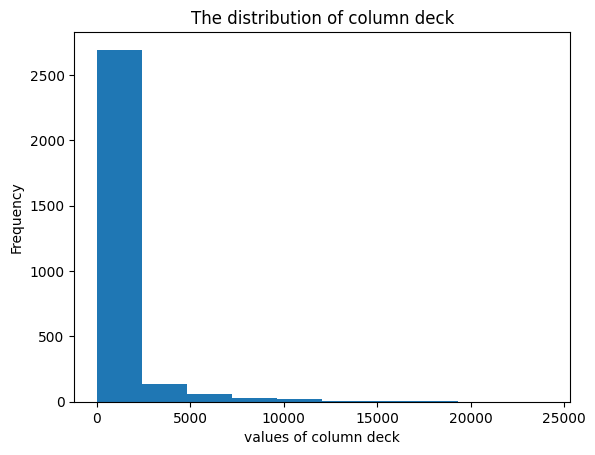

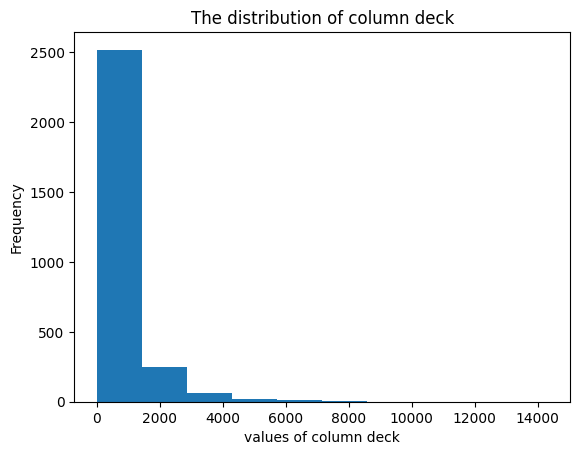

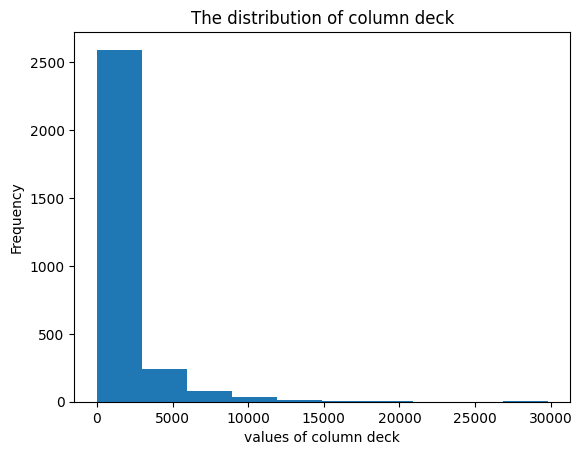

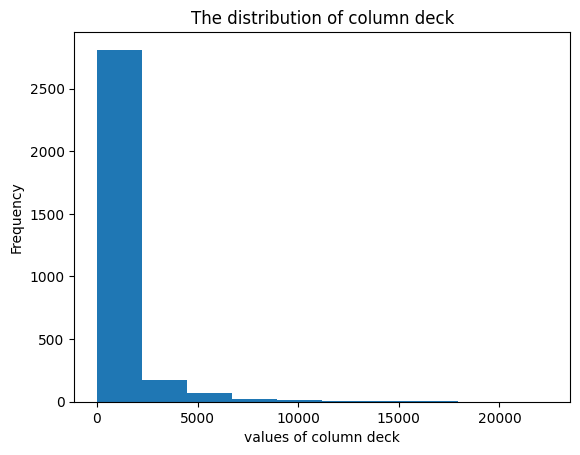

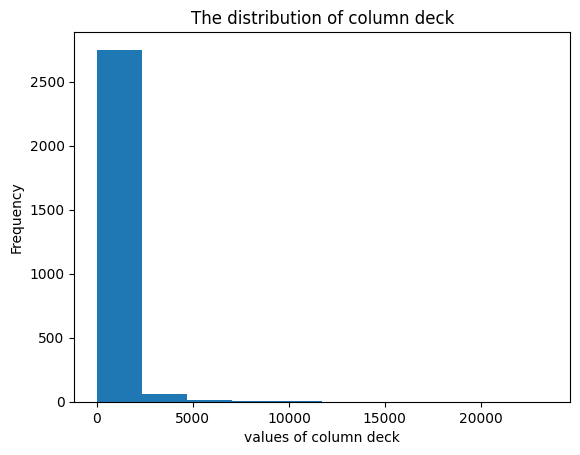

In [34]:
# the distribution of all spending columns are highly skewed. This should be addressed using log and bcox transformations
from scipy.stats import boxcox 
# let's consider the non-sleeping customers
for c in spending_cols[:-1]:
    g = df[df[c] != 0][c].plot(kind='hist')
    g.set(xlabel=f"values of column {n}", ylabel="Frequency")
    g.set_title(f'The distribution of column {n}')
    plt.show()    


In [41]:
# the distribution barely change even after excluding the rows with value zero.
# before proceeding with addressing the outliers let's consider the relation between the different spending columns
spending_cols
spending_df = df.loc[:, spending_cols].fillna(0).reset_index(drop=True)
print(spending_df.head())

    deck   room    food     spa   mall    total
0    0.0    0.0     0.0     0.0    0.0      0.0
1   44.0  109.0     9.0   549.0   25.0    736.0
2   49.0   43.0  3576.0  6715.0    0.0  10383.0
3  193.0    0.0  1283.0  3329.0  371.0   5176.0
4    2.0  303.0    70.0   565.0  151.0   1091.0


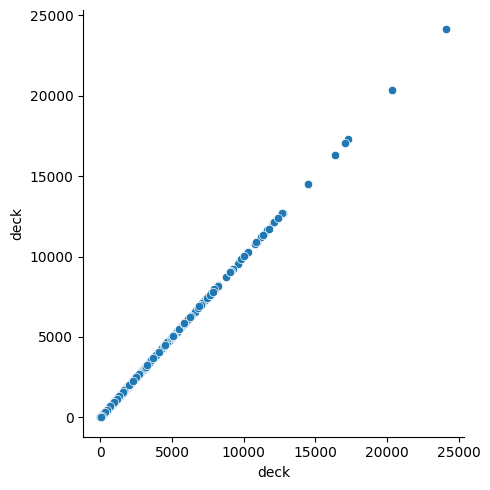

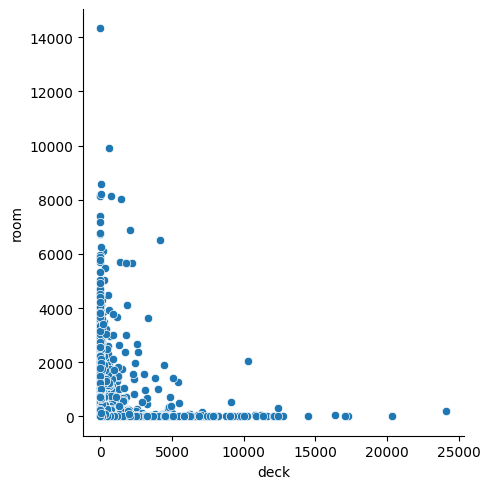

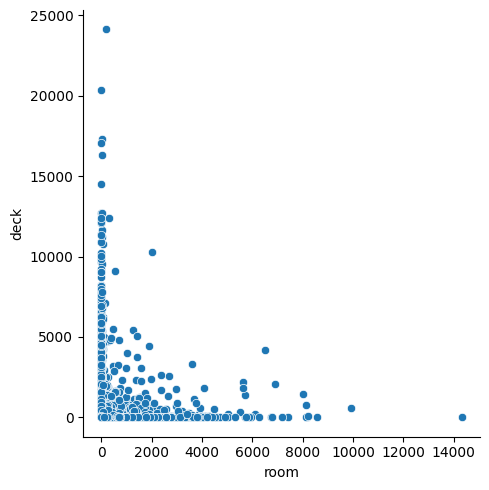

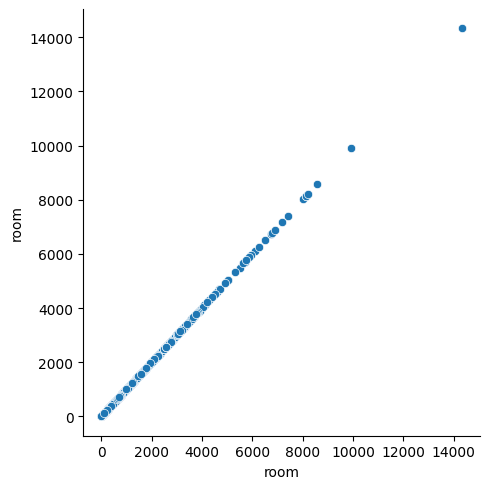

In [46]:
for c1 in spending_cols[:2]:
    for c2 in spending_cols[:2]:
        sns.relplot(data=df, x=c1, y=c2, kind='scatter')
        plt.show()

In [34]:
for c in spending_cols[:-1]:
    df[c], lamda = boxcox(1 + df[c])
    # use the lambda returned by the first call to transform the test dataset
    df_test[c] = boxcox(1 + df_test[c], lmbda = lamda)

In [ ]:
for n in num_cols:
    g = df[n].plot(kind='hist')
    g.set(xlabel=f"values of column {n}", ylabel="Frequency")
    g.set_title(f'The distribution of column {n}')
    plt.show()

In [ ]:
# as these numerical columns are now consideredvery close to normal,applying the z-score strategy seems like a good idea 


# housing['LQFSF_Stats'] = stats.zscore(housing['Low Qual Fin SF'])
# housing[['Low Qual Fin SF','LQFSF_Stats']].describe().round(3)
